In [1]:
# Import standard libraries
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
import scipy.stats as ss
import csv
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import pickle
from collections import defaultdict
import operator
from scipy.sparse import csr_matrix
import itertools
import os.path
import math
import pybedtools
# Import custom libraries
import process_hic_contacts_inter as phc

In [2]:
# Reload modules in case of modifications
reload(phc)

<module 'process_hic_contacts_inter' from '/home/louiscam/projects/gpcr/code/processing_hic/new_CD3Tcells_hic_preprocessing/process_hic_contacts_inter.py'>

In [114]:
# Specify directories and relevant information
genome_dir = '/home/louiscam/projects/gpcr/data/genome_data/'
processed_hic_dir = '/home/louiscam/projects/gpcr/save/processed_hic_data/'
saving_dir = '/home/louiscam/projects/gpcr/save/figures/'
cell_type = 'CD3T'
resol = 250000
quality = 'MAPQGE30'
norm = 'NONE'
chr1 = 1
chr2 = 2

### Load data

In [115]:
# Load normalized HiC data
normalized_hic_data = phc.get_normed_hic_sparse(processed_hic_dir, cell_type, resol, quality, chr1, chr2, norm)
normalized_hic_data.head()

,locus_chr1,locus_chr2,norm_value
0,34,0,1.0
1,70,0,1.0
2,108,0,1.0
3,142,0,1.0
4,164,0,1.0


In [116]:
# Get chromosome sizes
df_sizes = phc.get_chrom_sizes(genome_dir,resol)
chr1_size = int(df_sizes[df_sizes['chr']==str(chr1)]['size_loci'])
chr2_size = int(df_sizes[df_sizes['chr']==str(chr2)]['size_loci'])
df_sizes.head()

,chr,size,size_loci,size_roundup
0,1,249250621,998,249500000
1,2,243199373,973,243250000
2,3,198022430,793,198250000
3,4,191154276,765,191250000
4,5,180915260,724,181000000


In [117]:
# Get dense HiC dataframe
df = phc.get_dense_hic_dataframe(normalized_hic_data, chr1_size, chr2_size, resol)
df.head()

,0,250000,500000,750000,1000000,1250000,1500000,1750000,2000000,2250000,...,240750000,241000000,241250000,241500000,241750000,242000000,242250000,242500000,242750000,243000000
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
750000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


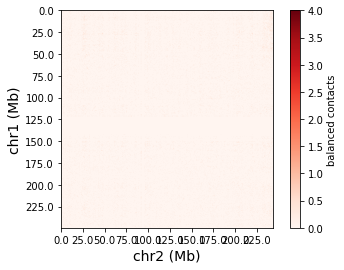

In [118]:
# Plot HiC dense dataframe
%matplotlib inline
plotname = ''
hic_plots_dir = ''
phc.plot_dense_hic_dataframe(df, chr1, chr2, plotname, hic_plots_dir, show=True)

In [119]:
# All-0 rows and columns
print(f'All-0 rows = {df.index.to_series()[df.sum(axis=1)==0].index.values}')
print(f'All-0 columns = {df.columns.to_series()[df.sum(axis=0)==0].index.values}')

All-0 rows = [   250000  13250000  13500000 120750000 121500000 121750000 122000000
 122250000 122500000 122750000 123000000 123250000 123500000 123750000
 124000000 124250000 124500000 124750000 125000000 125250000 125500000
 125750000 126000000 126250000 126500000 126750000 127000000 127250000
 127500000 127750000 128000000 128250000 128500000 128750000 129000000
 129250000 129500000 129750000 130000000 130250000 130500000 130750000
 131000000 131250000 131500000 131750000 132000000 132250000 132500000
 132750000 133000000 133250000 133500000 133750000 134000000 134250000
 134500000 134750000 135000000 135250000 135500000 135750000 136000000
 136250000 136500000 136750000 137000000 137250000 137500000 137750000
 138000000 138250000 138500000 138750000 139000000 139250000 139500000
 139750000 140000000 140250000 140500000 140750000 141000000 141250000
 141500000 141750000 142000000 142250000 144250000 146000000 148250000
 148500000 249250000]
All-0 columns = [ 88000000  89500000  9050

### Filter out centromeres

In [120]:
# Get centromere locations
df_centrom = phc.get_centromere_locations(genome_dir)
df_centrom.head()

,bin,chrom,chromStart,chromEnd,ix,n,size,type,bridge
0,23,chr1,121535434,124535434,1270,N,3000000,centromere,no
1,20,chr2,92326171,95326171,770,N,3000000,centromere,no
2,2,chr3,90504854,93504854,784,N,3000000,centromere,no
3,1,chr4,49660117,52660117,447,N,3000000,centromere,no
4,14,chr5,46405641,49405641,452,N,3000000,centromere,no


In [121]:
# Filter out centromeres
filter_size = 2000000
df = phc.filter_centromeres(df, chr1, 'row', df_centrom, filter_size, resol)
df = phc.filter_centromeres(df, chr2, 'col', df_centrom, filter_size, resol)

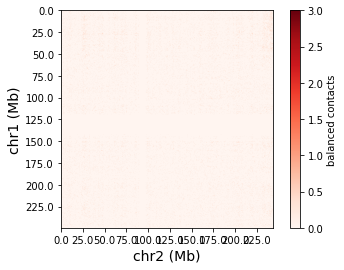

In [122]:
# Plot HiC data after filtering out centromeres
plotname = ''
hic_plots_dir = ''
phc.plot_dense_hic_dataframe(df, chr1, chr2, plotname, hic_plots_dir, show=True)

### Filter out repeats

In [123]:
# Filter repeats for chr1 and chr2
df = phc.filter_repeats(df, chr1, dic_repeats_tofilter, 'row')
df = phc.filter_repeats(df, chr2, dic_repeats_tofilter, 'col')

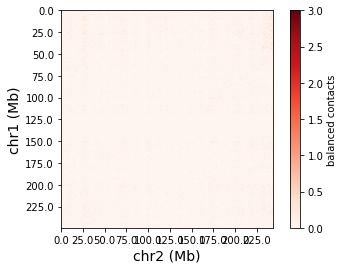

In [124]:
# Plot HiC data after filtering out centromeres
plotname = ''
hic_plots_dir = ''
phc.plot_dense_hic_dataframe(df, chr1, chr2, plotname, hic_plots_dir, show=True)

## Log-transform and filter out outliers

In [125]:
# Log-transform dataframe
df_transformed = phc.log_transform(df)

In [126]:
# Filter out outliers
df_transformed, _, _ = phc.filter_outliers(df_transformed)
#df_transformed = df_transformed*(df_transformed<1)

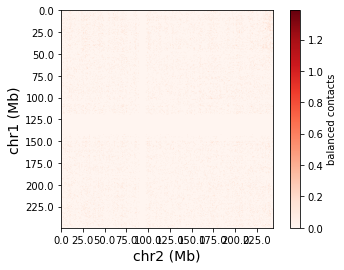

In [127]:
# Plot HiC data after filtering out centromeres, repeats and outliers
plotname = ''
hic_plots_dir = ''
phc.plot_dense_hic_dataframe(df_transformed, chr1, chr2, plotname, hic_plots_dir, show=True)

In [128]:
x = df_transformed.values.flatten()
x = x[x>0]
x

array([0.69314718, 0.69314718, 0.69314718, ..., 0.69314718, 0.69314718,
       0.69314718])

In [26]:
# Record nonzero entries
data = df_transformed.values
data_nonzero = data[np.nonzero(data)]

### Blacklisted locations

In [27]:
df = df_transformed.copy()

In [28]:
# Initialize empty dictionary
blacklist = defaultdict(list)

In [29]:
# Compute loci with zero values for chromosomes chr1 and chr2
zero_cols = df.columns[(df == 0).all(axis=0)]
blacklist[chr2].append(zero_cols)
zero_rows = df.index[(df == 0).all(axis=1)]
blacklist[chr1].append(zero_rows)

In [30]:
# Process the dicitonary
for chrom in blacklist.keys():
    values_list = blacklist[chrom]
    blacklist[chrom] = set(map(int, list(itertools.chain.from_iterable(values_list))))